There are a few instances, where prices are missing. We want to know how often they occur and how severe they are.


In [1]:
# We want to reload all modules before execution, each time, as we do not care about performance
# but easy development and we will be changing the modules a ton:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.environ.get('BLACK_SWAN_PATH'))

In [2]:
import operator
import functools
import numpy as np
import matplotlib.pyplot as plt
from strategy_simulation import Simulation, SimulationOptions

In [3]:
sim = Simulation()

Loaded 220 stocks from /home/notger-heinz/projects_and_analysis/black_swan_strategy/prices.
2 stocks were rejected for reason of having less than 1000 entries.
After filtering out 4192 rows with weird date formats, 10552 rows remain.
After removal of discontinuous stock price lists was skipped, 218 stocks are left.



/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Analyse the missing fields in the prices

In [4]:
is_na_df = sim.prices.isna()
is_na_matrix = is_na_df.values

In [5]:
# Find the number of status switches for each stock, where a status switch is when data becomes available 
# or ceases to be available:
status_switch = is_na_matrix[1:, :] != is_na_matrix[:-1, :]

In [6]:
# Stock-wise number of status switches over the history:
status_switch.sum(axis=0)

array([375, 376, 376, 376, 376, 376, 346, 376, 228, 358, 376, 376, 376,
       376, 376,   0, 290, 376, 376, 358, 260, 375, 375, 375, 376, 376,
       376, 190, 106, 176, 376, 324, 246, 376, 375, 376, 376, 376, 375,
       376, 376, 376, 376, 376, 375, 376, 376, 376, 358, 358, 376, 376,
       376, 376,   0, 144, 256, 376, 378, 126, 376, 358, 376, 254, 376,
       376, 376, 375, 376, 313, 376, 358, 376, 272, 376,  94, 376, 376,
       362, 313, 358, 376, 324, 313, 375, 375, 146, 282, 358, 376, 376,
       376, 226, 376, 156, 376, 376, 375, 376, 375, 358, 376, 376, 264,
       376, 375, 376, 376, 376, 366, 376, 134, 375, 326, 375, 376, 132,
       375, 375, 212, 368, 376, 376, 376, 375, 375, 122,   0, 276, 188,
       254, 358, 376, 210, 375, 332, 376, 376, 176, 376, 375, 370, 364,
       375, 374, 364, 376, 376, 376, 156, 375, 358, 358, 314, 376, 330,
       313, 376, 376, 166, 375, 376, 375, 308, 362, 376, 375, 375, 376,
       236, 376, 134, 358, 330, 376, 110, 376, 364, 358, 362, 37

**Learning**: There is a fairly consistent number of switches, which seems to indicate that the data has a common pattern of availability.

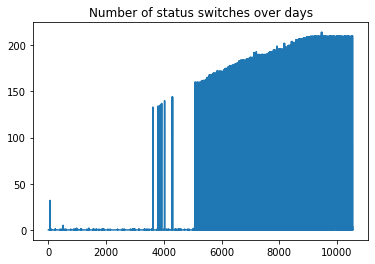

In [7]:
plt.plot(status_switch.sum(axis=1))
plt.title('Number of status switches over days')
plt.show()

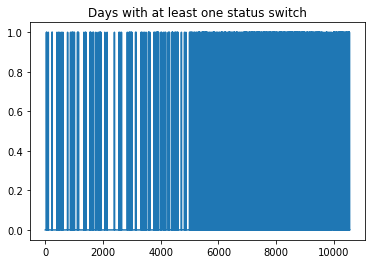

In [8]:
plt.plot(status_switch.sum(axis=1) > 0)
plt.title('Days with at least one status switch')
plt.show()

[]

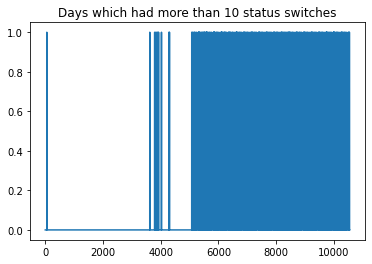

In [9]:
plt.plot(status_switch.sum(axis=1) > 10)
plt.title('Days which had more than 10 status switches')
plt.plot()

[]

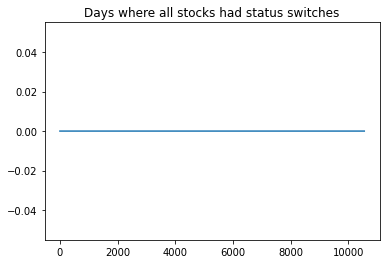

In [10]:
plt.plot(status_switch.sum(axis=1) == len(sim.prices.columns))
plt.title('Days where all stocks had status switches')
plt.plot()

**Learning**: Since about 2003 (index 6000'ish), there were fewer status switches, but if there some, they affect all stocks. Seems to be the missing data is training pauses.

In [11]:
# At which days did the training stops after happen?
sim.prices.index[6001:][status_switch[6000:, :].sum(axis=1) == len(sim.prices.columns)]

Index([], dtype='object', name='Date')

In [12]:
# We can now go through each stock in line and pairwise compare the indices of status switches.
# This should give us an idea of the length of the stopped data.
stock_missing_data_lengths = {}
for k, stock in enumerate(sim.prices):
    # If a stock starts with a nan, we need an offset for the switch-difference:
    stock_starts_with_nan = np.isnan(sim.prices[stock].iloc[0])
    
    # Now, there could also be a trailing nan, which means that we had the bad luck
    # of catching a stock right in the middle of a trading pause. Taking a difference
    # There becomes impossible, so we will end the loop earlier then:
    stock_ends_with_nan = np.isnan(sim.prices[stock].iloc[-1])
    
    # Get the switching dates and convert them to datetime (two lines, for readability ;) ):
    switching_dates = sim.prices.index[1:][status_switch[:, k]].values
    switching_dates = np.asarray([np.datetime64(d) for d in switching_dates])
    
    # Compare the date-pairs:
    date_differences = [
        ((switching_dates[i + 1] - switching_dates[i]) / np.timedelta64(1, 'D')).astype(int) 
        for i in range(
            int(stock_starts_with_nan), 
            len(switching_dates) - 1 + int(stock_starts_with_nan) - int(stock_ends_with_nan), 
            2
        )
    ]

    stock_missing_data_lengths[stock] = date_differences

In [13]:
all_missing_data_lengths = functools.reduce(operator.iconcat, [v for k, v in stock_missing_data_lengths.items()], [])
np.unique(all_missing_data_lengths, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  8, 10]),
 array([28935,   224,  6569,    36,     8,   177,     4,     4]))

All missing data slots are not longer than a week, and 70+% are just one day.